In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nn import Layer, FeedForwardNN, WeightInitializationOption, WeightInitializer, Activation, xavier_std
from sklearn.preprocessing import OneHotEncoder
from optimizers import RMSProp, StochasticGradientDescent, Adam
from metrics import mean_squared_error_loss, categorical_crossentropy_loss, to_float
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits


mnist_dataset = load_digits()

mnist_dataset.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]], shape=(1797, 64))

In [39]:
mnist_dataset.target

array([0, 1, 2, ..., 8, 9, 8], shape=(1797,))

Dataset shape: (1797, 64)
Labels shape: (1797,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


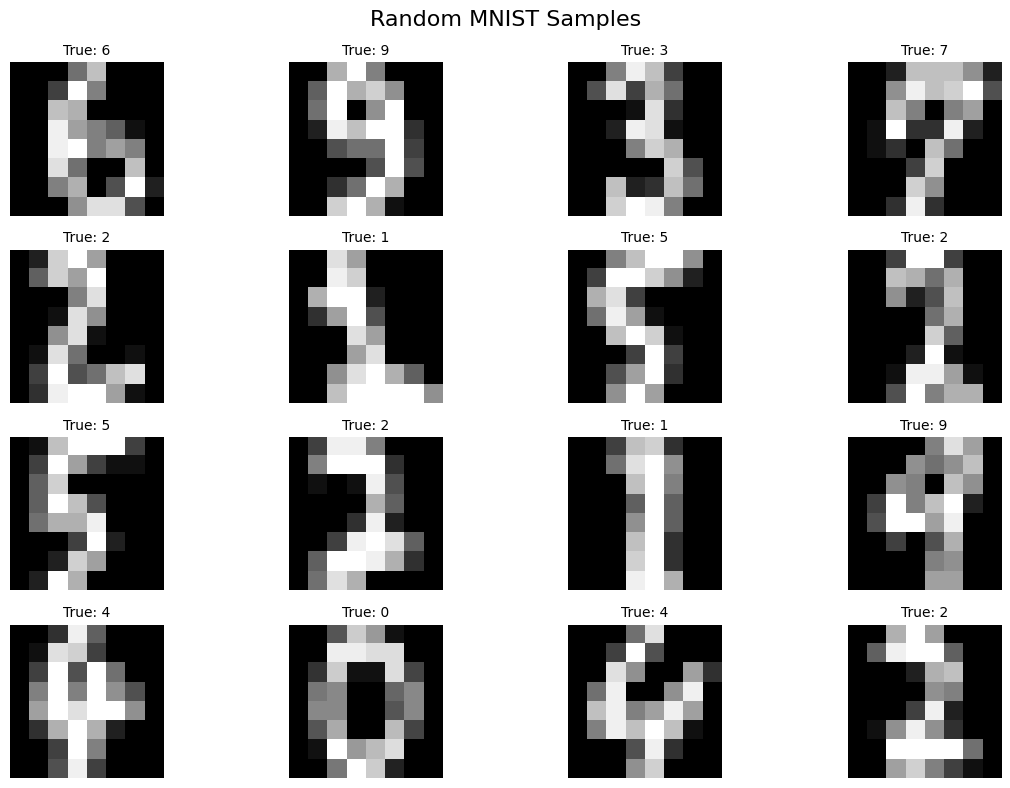

In [40]:
def visualize_samples(X, y_true, y_pred=None, num_samples=16, figsize=(12, 8), title="MNIST Samples"):
    num_samples = min(num_samples, len(X))
    
    # Calculate grid dimensions (roughly square)
    X = np.array(X)

    cols = int(np.ceil(np.sqrt(num_samples)))
    rows = int(np.ceil(num_samples / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easier indexing
    axes = axes.flatten() if num_samples > 1 else [axes]
    
    for i in range(num_samples):
        # Reshape flattened image back to 8x8
        image = X[i].reshape(8, 8)
        
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        
        # Create label text
        label_text = f"True: {y_true[i]}"
        if y_pred is not None:
            label_text += f"\nPred: {y_pred[i]}"
            # Color code: green if correct, red if incorrect
            color = 'green' if y_true[i] == y_pred[i] else 'red'
        else:
            color = 'black'
        
        axes[i].set_title(label_text, fontsize=10, color=color)
    
    # Hide empty subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_random_samples(X, y_true, y_pred=None, num_samples=16, seed=42):
    np.random.seed(seed)
    indices = np.random.choice(len(X), size=num_samples, replace=False)
    
    X_sample = X[indices]
    y_true_sample = y_true[indices]
    y_pred_sample = y_pred[indices] if y_pred is not None else None
    
    title = "Random MNIST Samples"
    if y_pred is not None:
        title += " (Green=Correct, Red=Incorrect)"
    
    visualize_samples(X_sample, y_true_sample, y_pred_sample, 
                     num_samples=num_samples, title=title)

def visualize_class_samples(X, y_true, target_class, num_samples=8):
    class_indices = np.where(y_true == target_class)[0]
    if len(class_indices) == 0:
        print(f"No samples found for class {target_class}")
        return
    
    # Select random samples from this class
    selected_indices = np.random.choice(class_indices, 
                                      size=min(num_samples, len(class_indices)), 
                                      replace=False)
    
    X_sample = X[selected_indices]
    y_true_sample = y_true[selected_indices]
    
    visualize_samples(X_sample, y_true_sample, 
                     num_samples=len(selected_indices),
                     title=f"Samples of Digit {target_class}")

# Test the visualization with the loaded data
print(f"Dataset shape: {mnist_dataset.data.shape}")
print(f"Labels shape: {mnist_dataset.target.shape}")
print(f"Unique labels: {np.unique(mnist_dataset.target)}")

# Visualize some random samples
visualize_random_samples(mnist_dataset.data, mnist_dataset.target, num_samples=16)

In [41]:
X = mnist_dataset.data
y = mnist_dataset.target.reshape(-1, 1)

#Take only first 400 images
X = X[:500]
y = y[:500]


onehot_encoder = OneHotEncoder()

y_onehot = onehot_encoder.fit_transform(y).toarray()



X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.15, random_state=42)
print(f"X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} y_test: {y_test.shape}")


X_train: (425, 64) y_train: (425, 10)
X_test: (75, 64) y_test: (75, 10)


In [42]:
y_train[:3]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [43]:
model = FeedForwardNN(
    layers=[
        Layer(
            n_input=64,
            n_output=32, 
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(1, 16))
        ),
        Layer(
            n_input=32,
            n_output=16, 
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 8))
        ),
        Layer(
            n_input=16,
            n_output=10, 
            activation=Activation.SOFTMAX,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(8, 8))
        )
    ]
)

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()


In [44]:
LR=0.01
BATCH_SIZE=16
EPOCHS=10

optimizer = Adam(parameters=model.parameters(), lr=LR)

model.fit(
            X_train=X_train,
            y_train=y_train,
            optimizer=optimizer,
            loss=categorical_crossentropy_loss,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            metric="accuracy",
            X_val=X_test,
            y_val=y_test,
            display_each_n_step=1
        )

2025-07-24 21:17:34.623 | INFO     | nn:fit:437 - Epoch 1/10  train_loss=11.9627  accuracy: 0.19294117647058823    val_loss=6.8839  val_accuracy=0.4267
2025-07-24 21:18:53.345 | INFO     | nn:fit:437 - Epoch 2/10  train_loss=3.4809  accuracy: 0.5388235294117647    val_loss=1.6206  val_accuracy=0.7200
2025-07-24 21:19:59.363 | INFO     | nn:fit:437 - Epoch 3/10  train_loss=1.0246  accuracy: 0.7529411764705882    val_loss=0.6057  val_accuracy=0.8000
2025-07-24 21:21:32.534 | INFO     | nn:fit:437 - Epoch 4/10  train_loss=0.5343  accuracy: 0.851764705882353    val_loss=0.3881  val_accuracy=0.8400
2025-07-24 21:22:57.311 | INFO     | nn:fit:437 - Epoch 5/10  train_loss=0.3401  accuracy: 0.88    val_loss=0.3862  val_accuracy=0.8933
2025-07-24 21:24:07.528 | INFO     | nn:fit:437 - Epoch 6/10  train_loss=0.2684  accuracy: 0.9035294117647059    val_loss=0.2944  val_accuracy=0.9067
2025-07-24 21:25:14.113 | INFO     | nn:fit:437 - Epoch 7/10  train_loss=0.1228  accuracy: 0.9529411764705882    

In [45]:
y_test_predictions = to_float(model.forward_batch(X_test))
y_test_prediction_labels = [int(np.argmax(pred)) for pred in y_test_predictions]
y_test_true_labels = [int(np.argmax(yt)) for yt in y_test]


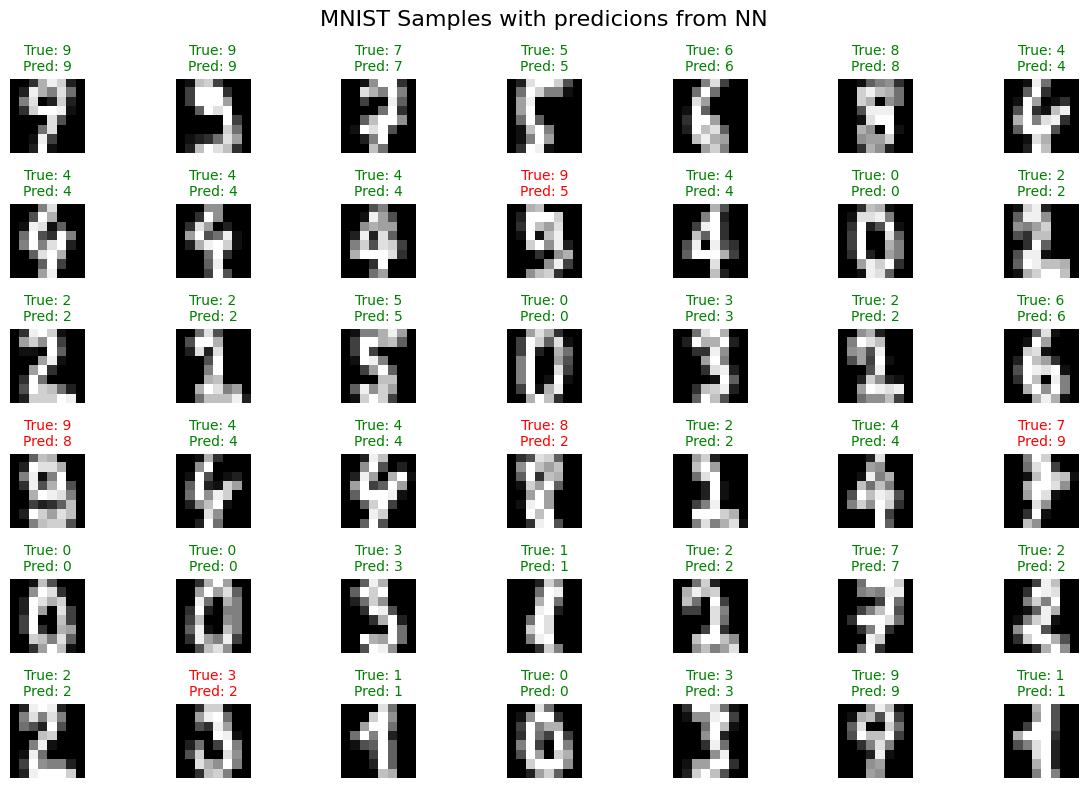

In [47]:
visualize_samples(X_test, y_true=y_test_true_labels, y_pred=y_test_prediction_labels, title="MNIST Samples with predicions from NN", num_samples=42)